In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, SGDRegressor, LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping



bicycle = pd.read_csv('c:/users/ps712/onedrive/ps/aibi/Dbicycle/dataset/train.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [77]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(bicycle.columns):
        missing_values = sum(bicycle[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(bicycle.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(bicycle)

결측치가 존재하지 않습니다


In [78]:
bicycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


## date time 날짜분리

In [79]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(bicycle)
    
bicycle['year'] = year
bicycle['month'] = month
bicycle['day'] = day

bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5


### 요일 추가

In [80]:
week_day = pd.to_datetime(bicycle['date_time']).dt.day_name()
bicycle['week_day'] = week_day
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week_day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,Sunday
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,Monday
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,Tuesday
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,Wednesday
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,Thursday


### 상관관계분석

In [81]:
bicycle_number = bicycle.select_dtypes(np.number)

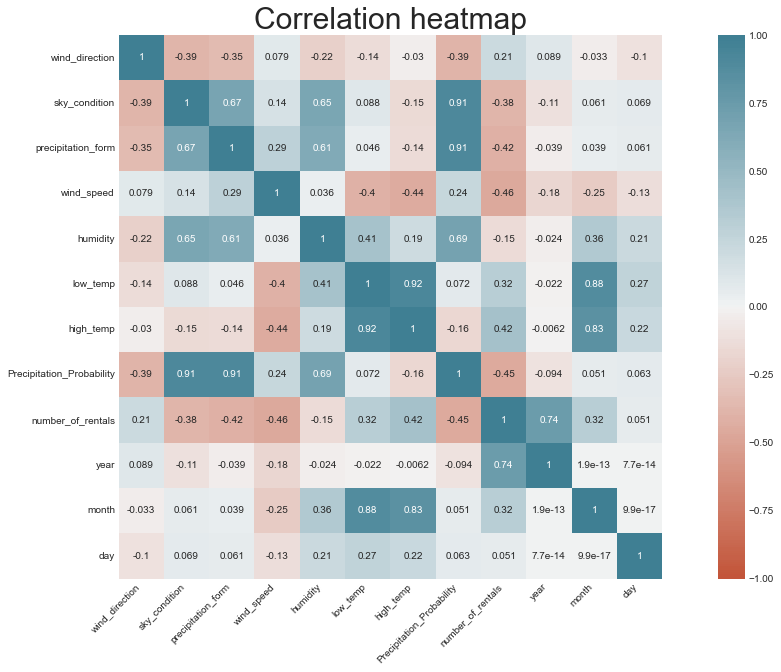

In [82]:
corr = bicycle_number.corr()
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Correlation heatmap', fontsize=30)
plt.show()
#대여량과 상곤계수가 높은것 연도, 온도,바람컨디션

### 연도,월,일자별 분석 

In [83]:
year_rentals = bicycle.groupby('year').sum()['number_of_rentals']
month_rentals = bicycle.groupby('month').sum()['number_of_rentals']
day_rentals = bicycle.groupby('day').sum()['number_of_rentals']

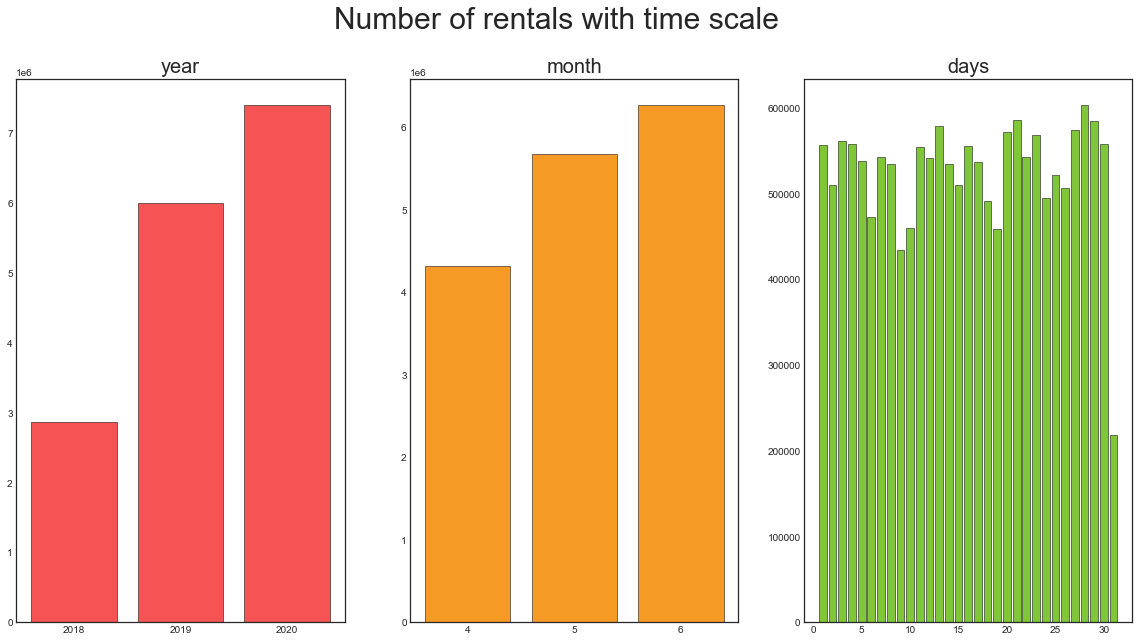

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Number of rentals with time scale', fontsize=30)

ax[0].bar(x=['2018', '2019', '2020'], height=year_rentals, color='#f55354', edgecolor='black')
ax[0].set_title('year', fontsize = 20)

ax[1].bar(x = ['4', '5', '6'], height=month_rentals, color='#f59b25', edgecolor='black')
ax[1].set_title('month', fontsize = 20)

ax[2].bar(x=day_rentals.index.to_list(), height= day_rentals, color='#7fc638', edgecolor='black')
ax[2].set_title('days', fontsize = 20)

plt.show()

### 요일별 분석

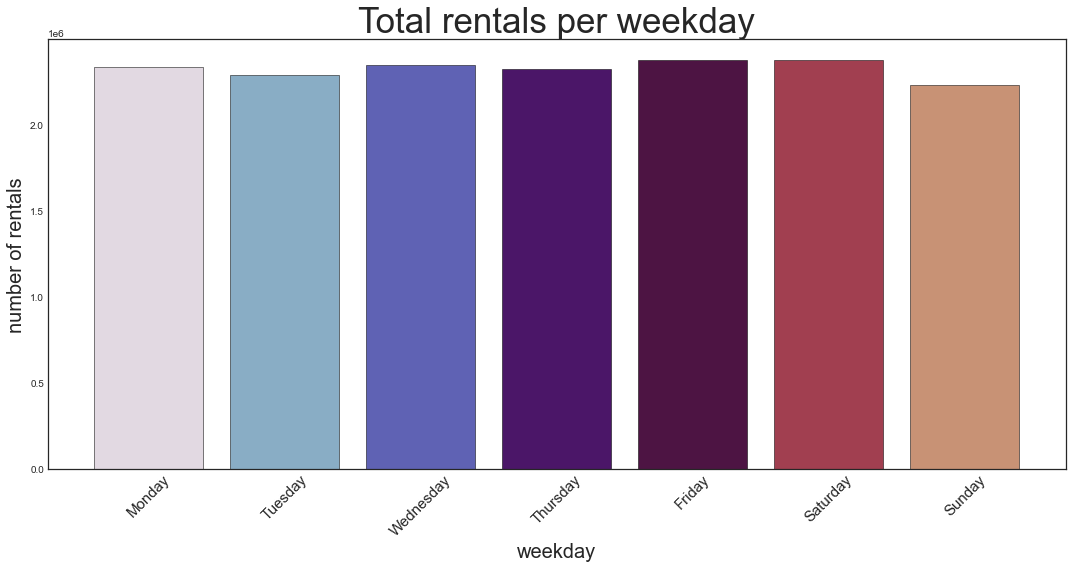

In [85]:
day_table = bicycle.groupby('week_day').sum()
day_table = day_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
plt.bar(day_table.index, day_table.number_of_rentals, edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total rentals per weekday', fontsize=35)
plt.xlabel('weekday', fontsize=20)
plt.ylabel('number of rentals', fontsize=20)
plt.tight_layout()
plt.show()

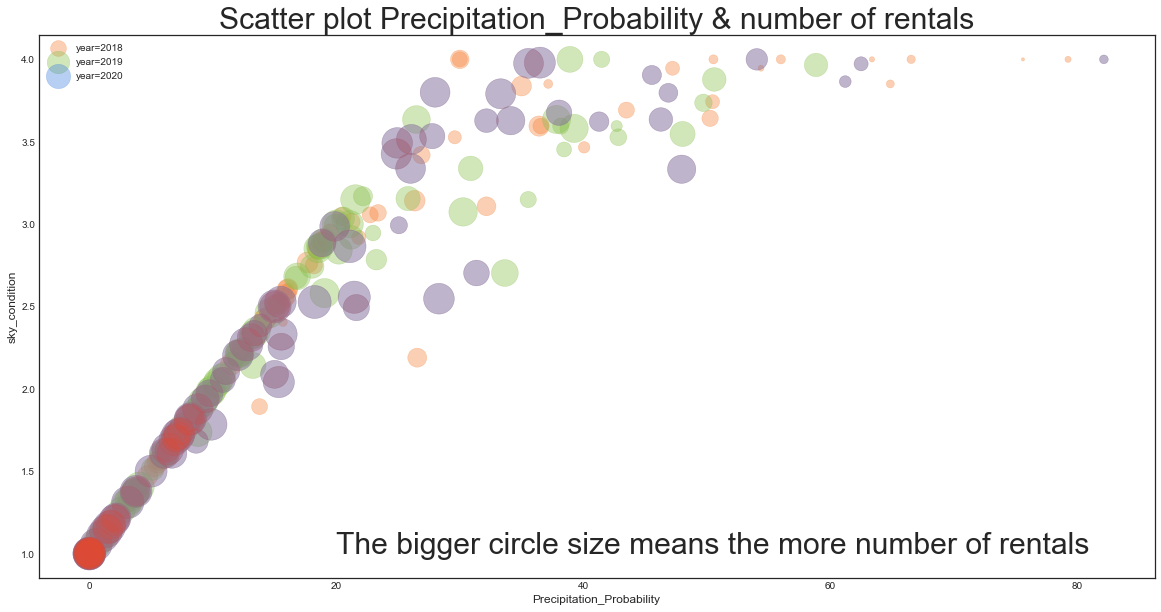

In [86]:
years = [2018, 2019, 2020]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize=(20, 10))

for year, color in zip(years, colors):
    
    precipitation_prb = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['number_of_rentals']
    sky_condition = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'year={year}')


plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

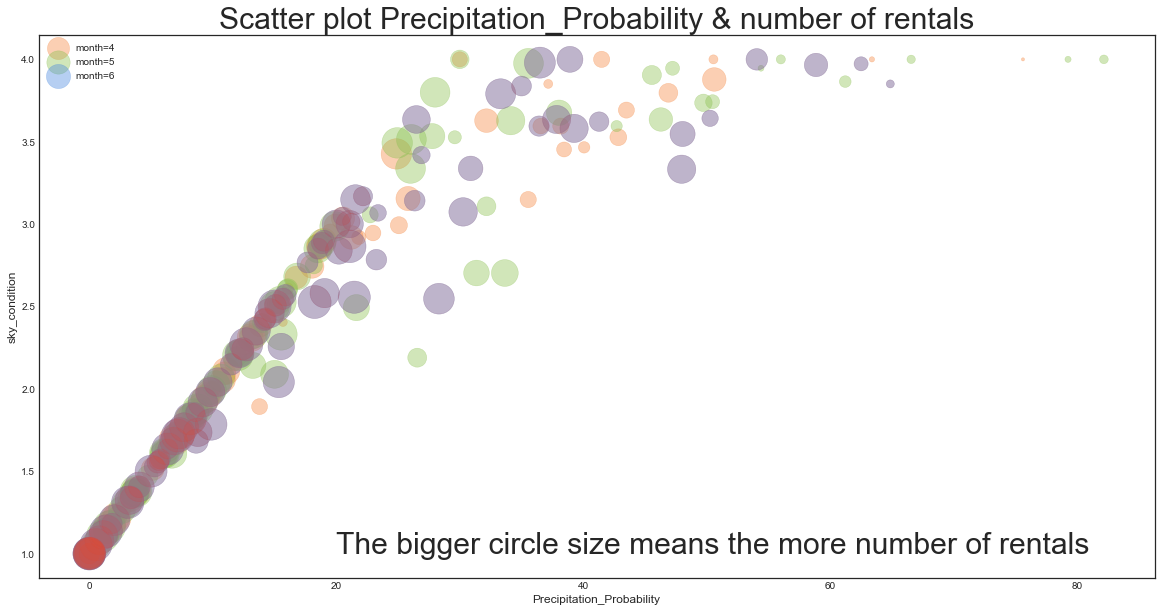

In [87]:
monthes = [4, 5, 6]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize=(20, 10))

for month, color in zip(monthes, colors):
    
    precipitation_prb = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['number_of_rentals']
    sky_condition = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'month={month}')


plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

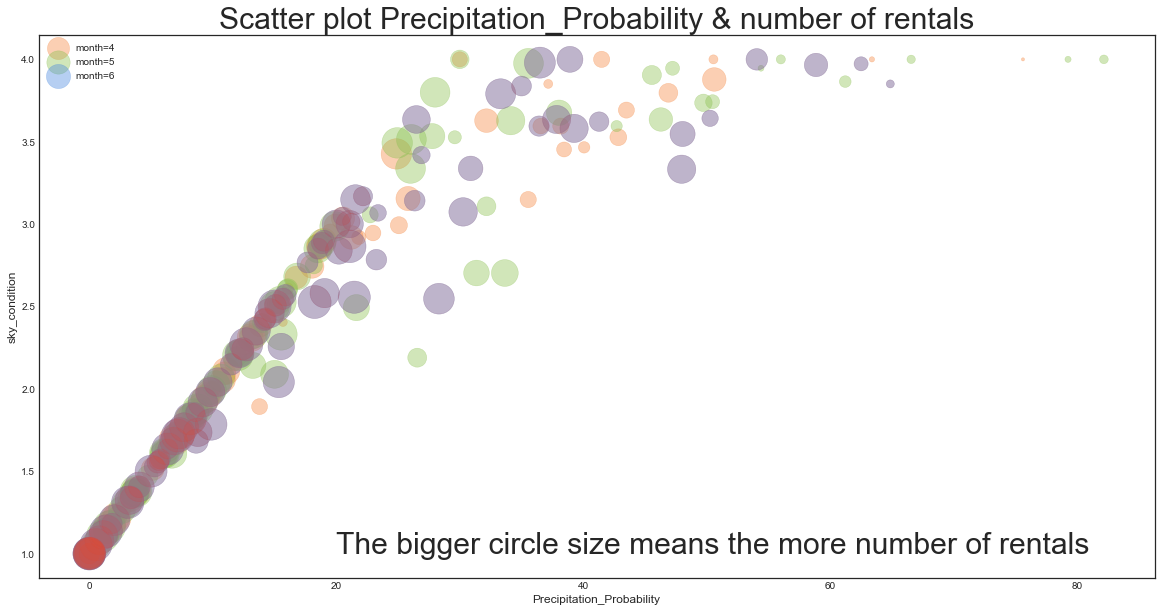

In [88]:
monthes = [4, 5, 6]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize=(20, 10))

for month, color in zip(monthes, colors):
    
    precipitation_prb = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['number_of_rentals']
    sky_condition = bicycle[bicycle['month'] == month].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'month={month}')


plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

In [113]:
X = bicycle.drop(['date_time','number_of_rentals'], axis=1)
y = bicycle.number_of_rentals

In [114]:
X_combination = X.copy()

In [115]:
# 요일 카테고리화(라벨링)
le = LabelEncoder()
le.fit(week_day)
X_combination['week_day'] = le.transform(week_day)

# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_combination['temp_diff_info'] = X_combination['high_temp'] - X_combination['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_combination['sweat_info'] = X_combination['high_temp'] * X_combination['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_combination['cold_info'] = X_combination['low_temp'] * X_combination['wind_speed'] 

# 4. 강수정보에 가중을 더줌

X_combination['rainy_info1'] = X_combination['humidity'] * X_combination['precipitation_form'] 
X_combination['rainy_info2'] = X_combination['humidity'] * X_combination['Precipitation_Probability'] 
X_combination['rainy_info3'] = X_combination['humidity'] * X_combination['sky_condition'] 
X_combination['rainy_info4'] = X_combination['Precipitation_Probability'] * X_combination['precipitation_form'] 
X_combination['rainy_info5'] = X_combination['Precipitation_Probability'] * X_combination['sky_condition'] 
X_combination['rainy_info6'] = X_combination['precipitation_form'] * X_combination['sky_condition'] 


X_combination['himidityw1'] = X_combination['humidity'] * X_combination['humidity'] 
X_combination['percipation_formw1'] = X_combination['precipitation_form'] * X_combination['precipitation_form'] 
X_combination['Precipitation_Probabilityw1'] = X_combination['Precipitation_Probability'] * X_combination['Precipitation_Probability'] 
X_combination['sky_condition'] = X_combination['sky_condition'] * X_combination['sky_condition'] 


X_combination['year'] = X_combination['year']  
X_combination['month'] = X_combination['month']  



In [116]:
X_combination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wind_direction               273 non-null    float64
 1   sky_condition                273 non-null    float64
 2   precipitation_form           273 non-null    float64
 3   wind_speed                   273 non-null    float64
 4   humidity                     273 non-null    float64
 5   low_temp                     273 non-null    float64
 6   high_temp                    273 non-null    float64
 7   Precipitation_Probability    273 non-null    float64
 8   year                         273 non-null    int64  
 9   month                        273 non-null    int64  
 10  day                          273 non-null    int64  
 11  week_day                     273 non-null    int32  
 12  temp_diff_info               273 non-null    float64
 13  sweat_info          

In [117]:
X_combination = X_combination.drop(['day','wind_direction','wind_speed','low_temp','high_temp'], axis=1)


In [118]:
# col_list = X_combination.columns

# # 이중 for문을 사용하여 변수 자기 자신의 제곱과 두 변수간의 곱이라는 새로운 변수를 추가합니다.
# for i in range(len(col_list)):
#     for j in range(i, len(col_list)):
#         X_combination[f'{col_list[i]}*{col_list[j]}'] = X_combination[col_list[i]] * X_combination[col_list[j]]

# X_combination

In [119]:
X_combination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sky_condition                273 non-null    float64
 1   precipitation_form           273 non-null    float64
 2   humidity                     273 non-null    float64
 3   Precipitation_Probability    273 non-null    float64
 4   year                         273 non-null    int64  
 5   month                        273 non-null    int64  
 6   week_day                     273 non-null    int32  
 7   temp_diff_info               273 non-null    float64
 8   sweat_info                   273 non-null    float64
 9   cold_info                    273 non-null    float64
 10  rainy_info1                  273 non-null    float64
 11  rainy_info2                  273 non-null    float64
 12  rainy_info3                  273 non-null    float64
 13  rainy_info4         

In [120]:
x_train, x_test, y_train, y_test = train_test_split(X_combination, y, test_size=0.3)

In [121]:
print("학습데이터  : {}\t레이블: {}".format(x_train.shape, y_train.shape))
print("테스트데이터  : {}\t레이블: {}".format(x_test.shape, y_test.shape))

학습데이터  : (191, 19)	레이블: (191,)
테스트데이터  : (82, 19)	레이블: (82,)


In [122]:
# train_stats = x_train.describe()
# train_stats
# train_stats = train_stats.transpose()
# train_stats

In [123]:
# # 데이터 정규화

# def normalization(x):
#     return (x - train_stats['mean']) / train_stats['std']

# x_train = normalization(x_train)
# x_test = normalization(y_train)

In [112]:
# mean = np.mean(x_train, axis=0)
# std = np.std(x_train, axis=0)
# x_train = (x_train -mean)/std
# # x_test = (x_test - mean) /std

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3,random_state=111)

In [132]:
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

IndexError: tuple index out of range

In [124]:
model1 = Sequential([Dense(100, activation='relu', input_shape=(19,), name='dense1'),
                    Dense(64, activation='relu', name='dense2'),
                    Dense(32, activation='relu', name='dense3'),
                    Dense(1, name='output')])

In [125]:
model1.compile(loss='mse',
              optimizer=Adam(learning_rate=1e-2),
              metrics=['mae'])

In [126]:
history = model1.fit(x_train, y_train, epochs=300,
                    validation_data=(x_test, y_test), verbose=0)

In [127]:
model1.evaluate(x_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 449493632.0000 - mae: 17485.1309


[449493632.0, 17485.130859375]

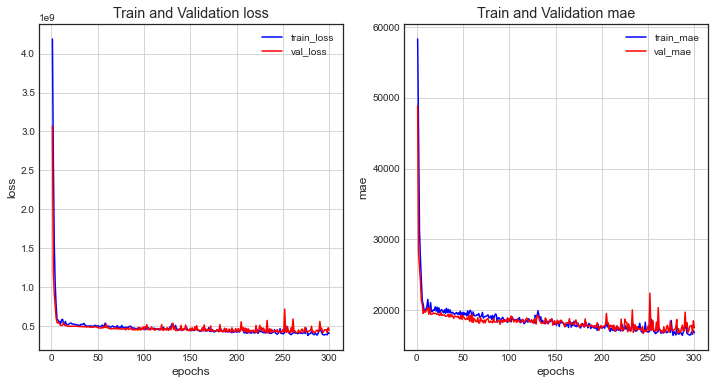

In [128]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,6))
ax1 =fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 =fig.add_subplot(1,2,2)
ax2.plot(epochs, mae, color='blue', label='train_mae')
ax2.plot(epochs, val_mae, color='red', label='val_mae')
ax2.set_title('Train and Validation mae')
ax2.set_xlabel('epochs')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()   

plt.show()

In [70]:
# y 예측
#y_hat = model.predict(X_combination)
y_hat1 = model1.predict(X_combination)

In [71]:
y = np.array(y)

In [72]:
#nmae = np.mean(abs(y_hat - y) / y)
nmae_1 = np.mean(abs(y_hat1 - y) / y)

#print(f'모델 NMAE: {nmae}')
print(f'모델 NMAE: {nmae_1}')


모델 NMAE: 1.1774242794333603


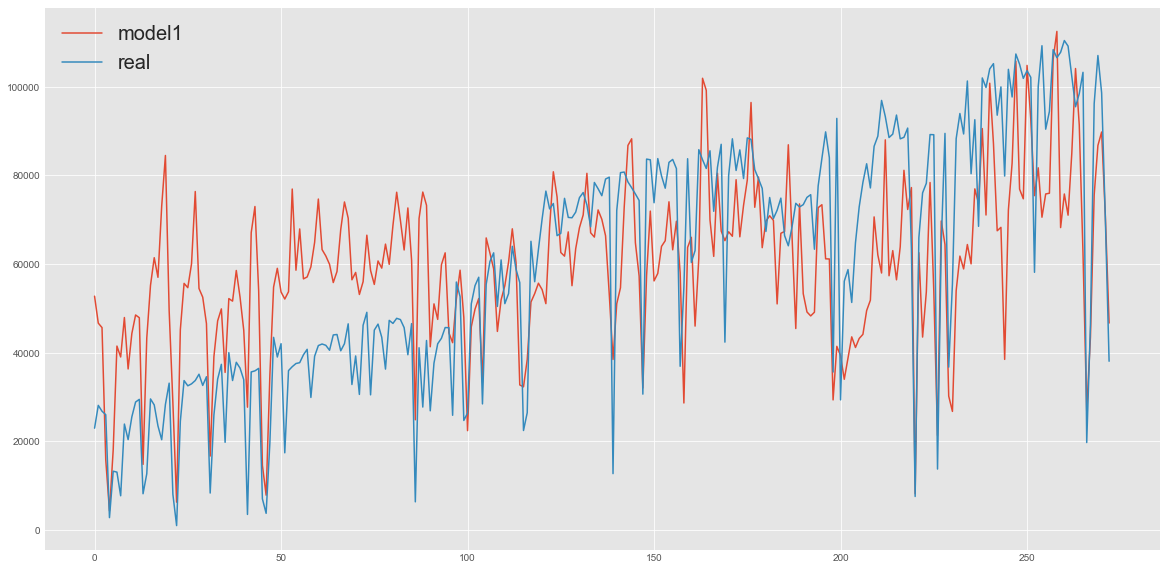

In [73]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
#plt.plot(y_hat, label = 'model')
plt.plot(y_hat1, label = 'model1')
plt.plot(y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

test = pd.read_csv('c:/users/ps712/onedrive/ps/aibi/Dbicycle/dataset/test.csv') # 데이터를 불러온 뒤
submission  = pd.read_csv('c:/users/ps712/onedrive/ps/aibi/Dbicycle/dataset/sample_submission.csv')

check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리 후 

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day

# date_time은 제거합니다.
test_X = test.drop('date_time', axis = 1)

# 요일 정보 추가

week_day = pd.to_datetime(test['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
test_X['week_day'] = le.transform(week_day)

# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
test_X['temp_diff_info'] = test_X['high_temp'] - test_X['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
test_X['sweat_info'] = test_X['high_temp'] * test_X['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
test_X['cold_info'] = test_X['low_temp'] * test_X['wind_speed'] 

test_X = test_X.drop(['day','wind_direction','wind_speed','low_temp','high_temp'], axis=1)

test_X['rainy_info1'] = test_X['humidity'] * test_X['precipitation_form'] 
test_X['rainy_info2'] = test_X['humidity'] * test_X['Precipitation_Probability'] 
test_X['rainy_info3'] = test_X['humidity'] * test_X['sky_condition'] 
test_X['rainy_info4'] = test_X['Precipitation_Probability'] * test_X['precipitation_form'] 
test_X['rainy_info5'] = test_X['Precipitation_Probability'] * test_X['sky_condition'] 
test_X['rainy_info6'] = test_X['precipitation_form'] * test_X['sky_condition'] 


test_X['himidityw1'] = test_X['humidity'] * test_X['humidity'] 
test_X['percipation_formw1'] = test_X['precipitation_form'] * test_X['precipitation_form'] 
test_X['Precipitation_Probabilityw1'] = test_X['Precipitation_Probability'] * test_X['Precipitation_Probability'] 
test_X['sky_condition'] = test_X['sky_condition'] * test_X['sky_condition'] 

test_X['year'] = test_X['year'] 
test_X['month'] = test_X['month']  



test_X


# 두 변수간의 곱 변수를 추가합니다.
col_list = test_X.columns

for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        test_X[f'{col_list[i]}*{col_list[j]}'] = test_X[col_list[i]] * test_X[col_list[j]]
        
test_X

test_yhat_lgbm = lgbm.predict(test_X)
submission['number_of_rentals'] = test_yhat_lgbm
submission.to_csv('sample_submission_lgbm.csv', index= False)


test_yhat_xgbr = xgbr.predict(test_X)
submission['number_of_rentals'] = test_yhat_xgbr
submission.to_csv('sample_submission_xgbr.csv', index= False)
